# Analysis of monthly return data

## Description

- Calculate mean return per Style

In [1]:
import feather
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

In [2]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AffinityPropagation

from sklearn.preprocessing import Normalizer, MaxAbsScaler

# Setup

In [115]:
# Convert to date format
begin_date = '2016-01-01' 
end_date = '2019-01-01'

## Load Data

### Returns

In [116]:
path = '../data/processed/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

# Convert to date format and filter based on date
returns['date'] =  pd.to_datetime(returns['caldt'], format='%Y-%m-%d')
returns = returns[returns['date'] > begin_date]

### Summary

In [117]:
path = '../data/processed/EDY/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(159970, 6)

In [118]:
# Convert to date format and filter based on date with mask that is also used on holdings
summary['date'] =  pd.to_datetime(summary['report_dt'], format='%Y-%m-%d')
date_mask = summary['date'] > begin_date
summary = summary[date_mask]
summary.shape

(39596, 7)

### Holdings

In [119]:
path = '../data/processed/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(159970, 28210)

In [120]:
holdings = holdings[date_mask.values]

In [121]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(39596, 7)
Shape of holding information
(39596, 28210)


### portno_map

In [122]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

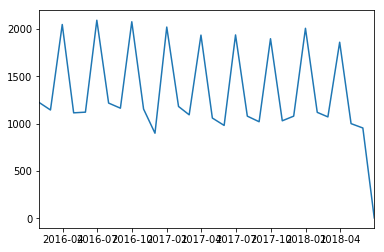

In [123]:
summary['report_dt'].value_counts().plot()

## Merge Lipper_class onto returns data

### Merge does not take dates into account -> TODO

In [124]:
summary.dtypes

port_no                  int64
report_dt               object
lipper_class            object
cap_class               object
style_class             object
fund_no                float64
date            datetime64[ns]
dtype: object

In [125]:
returns.head(1)

,crsp_fundno,caldt,mret,date
156,105.0,2016-01-29,-0.062806,2016-01-29


In [126]:
#returns_merged = returns.merge(summary, how='left', left_on=['crsp_fundno','date'],right_on=['fund_no','date'])
returns_merged = returns.merge(summary, how='left', left_on=['crsp_fundno'],right_on=['fund_no'])
returns_merged.shape

(1592961, 11)

In [127]:
returns_merged = returns_merged.drop(columns=['report_dt','fund_no'])

In [128]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(1342148, 9)

#### Take only needed columns and reorder them

In [129]:
returns_merged = returns_merged[['port_no','caldt','mret','lipper_class','style_class','cap_class']]

In [130]:
returns_merged.sample()

,port_no,caldt,mret,lipper_class,style_class,cap_class
1331047,1030158.0,2018-09-28,0.001001,EIEI,E,E


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [131]:
group_by = 'style_class'

In [132]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values
obj_codes

array(['C', 'G', 'V', 'E'], dtype=object)

In [133]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [134]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [135]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [136]:
returns_obj_n = returns_obj.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns=group_by)

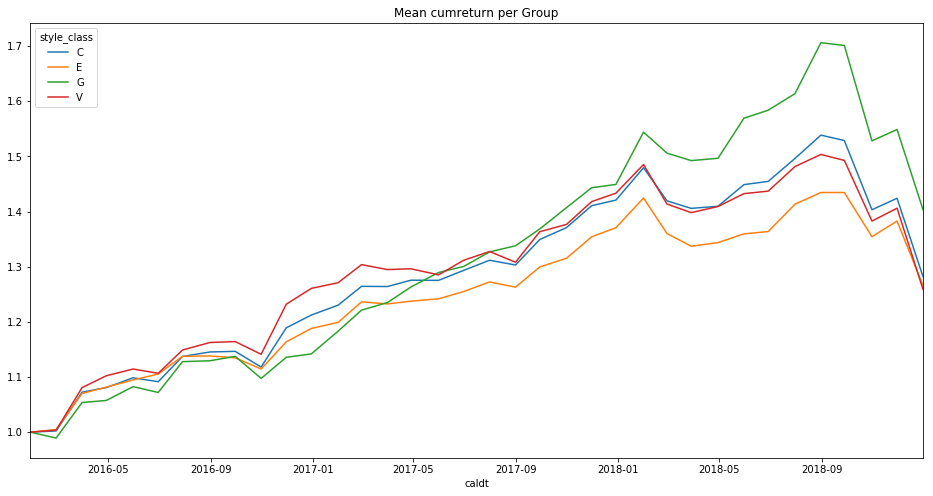

In [137]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [140]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [141]:
holdings = transformer.transform(holdings)

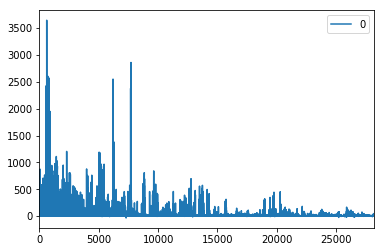

In [142]:
pd.DataFrame(holdings.sum(0)).T.plot()

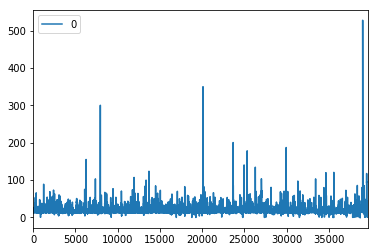

In [143]:
pd.DataFrame(holdings.sum(1)).plot()

In [96]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 3,
                verbose = True,
                n_init = 10, # Number of runs
                n_jobs= -1,
                random_state=0).fit(holdings)

Start kMeans...


In [97]:
lables = pd.DataFrame(kmeans.labels_)

In [98]:
summary['cluster'] = lables.values

In [99]:
pd.crosstab(summary['cap_class'],summary['cluster'])

cluster,0,1,2
cap_class,,,
E,440,0,15
L,718,22,1223
M,1687,1,465
S,1442,0,1


In [100]:
pd.crosstab(summary['style_class'],summary['cluster'])

cluster,0,1,2
style_class,,,
C,1707,22,666
E,440,0,15
G,1025,1,1015
V,1115,0,8


## Chart the returns of the formed clustes

In [101]:
summary.sample()

,port_no,report_dt,lipper_class,cap_class,style_class,fund_no,date,cluster
124185,1027635,2018-01-31,MLCE,M,C,8290.0,2018-01-31,0


#### Merge new clusters into returns

In [102]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
17766,2018-03-29,10202.0,1022766.0,-0.002919,SCCE,0.0


#### Calc mean return per Obj_cd

In [103]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([0., 2., 1.])

In [104]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [105]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

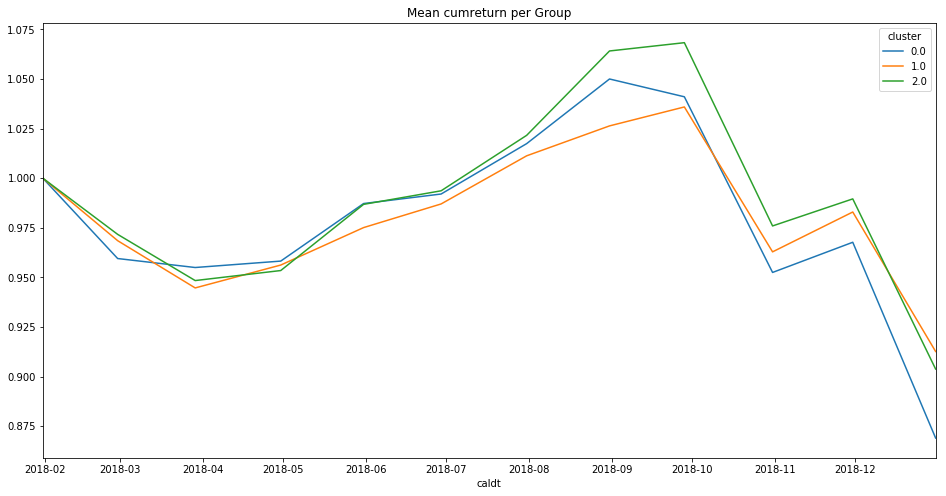

In [106]:
returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

# Visualize

In [ ]:
MiniBatchKMeans?

For n_clusters = 2 The average silhouette_score is : 0.7246336817269491
For n_clusters = 3 The average silhouette_score is : 0.049851634609341375
For n_clusters = 4 The average silhouette_score is : -0.01807440006736926
For n_clusters = 5 The average silhouette_score is : -0.02801882821717202


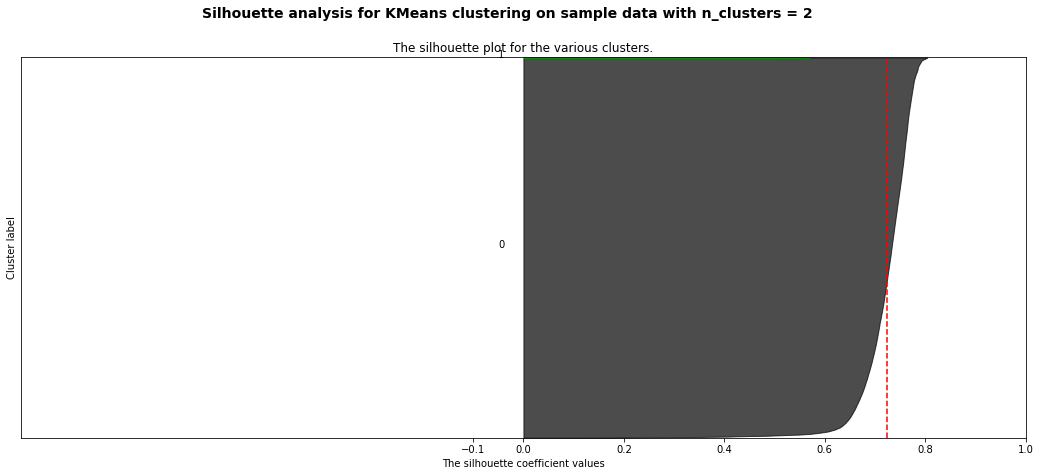

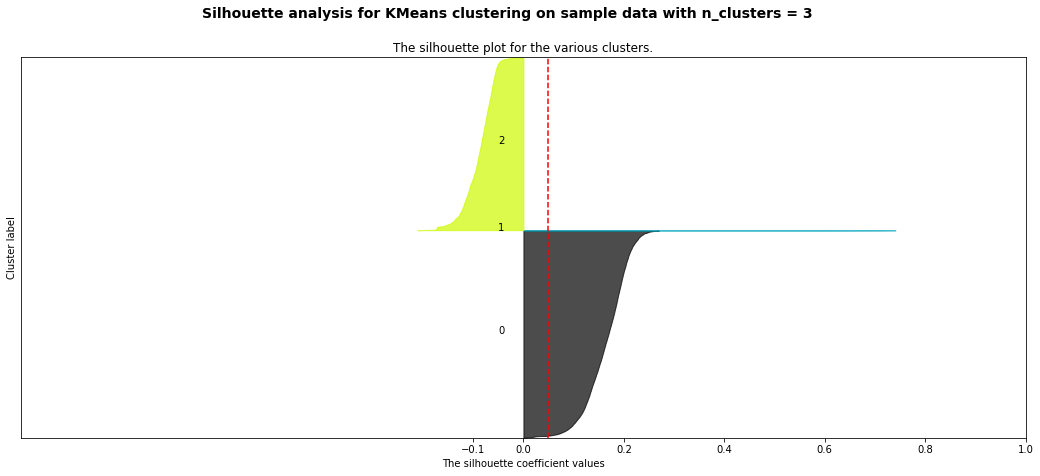

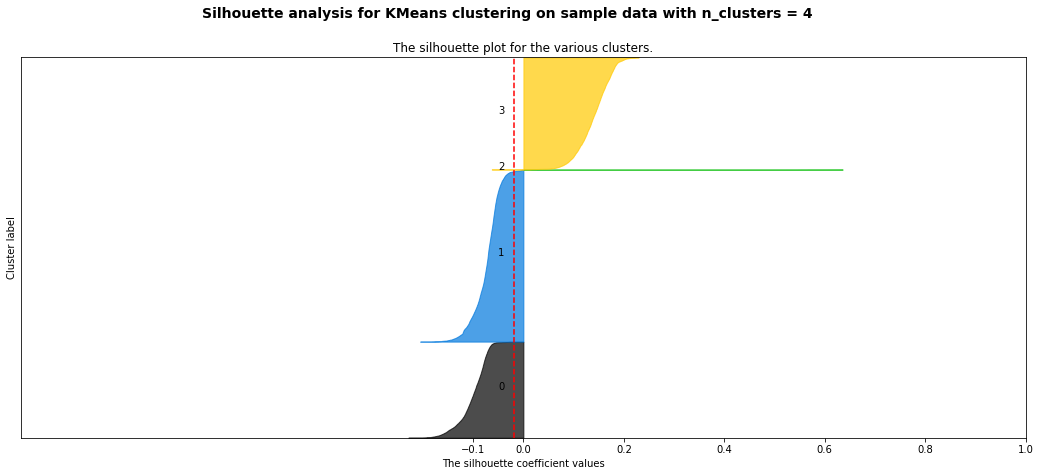

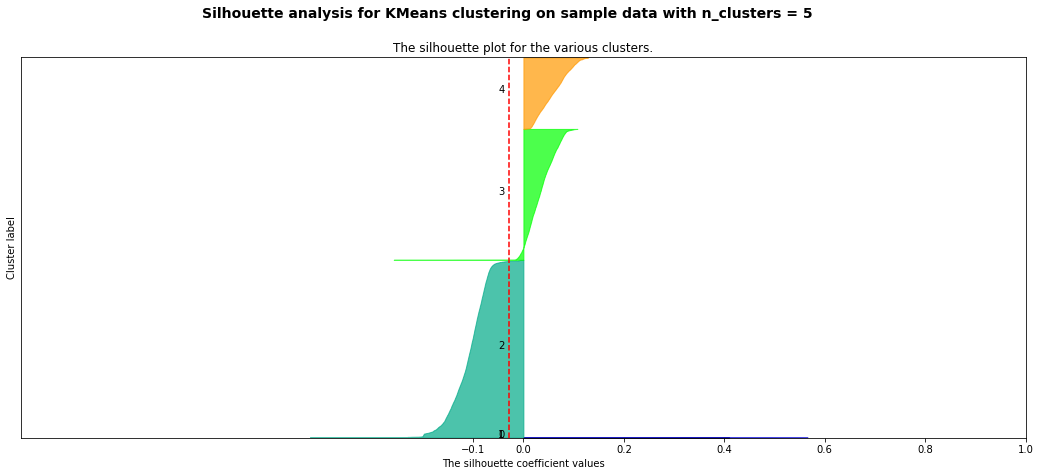

CPU times: user 7min 45s, sys: 1min 13s, total: 8min 59s
Wall time: 9min


In [144]:
### Based on example code from sklearn ###

%%time
X = holdings
n_clusters = [2,3,4,5]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()